# Math modeling in Climate Research

## Tutorial 6 - A simple SWE solver

References:

[1] Klein R., Vater S., Päschke E., Ruprecht D., "*Multiple scales methods in meteorology*", 
in: Asymptotic Methods in Fluid Mechanics: Survey and Recent Advances, 
Springer Series: CISM International Centre for Mechanical Sciences, 523, 127--196, (2011)

[2] Bouchut, François., "*Efficient numerical finite volume schemes for shallow water models.*", Edited Series on Advances in Nonlinear Science and Complexity 2 (2007): 189-256.

[3] Audusse, Emmanuel, et al., "*A fast and stable well-balanced scheme with hydrostatic reconstruction for shallow water flows.*" SIAM Journal on Scientific Computing 25.6 (2004): 2050-2065.

In [1]:
# Simple shallow water solver
# Partially adapted from: https://people.sc.fsu.edu/~jburkardt/py_src/shallow_water_1d/shallow_water_1d.py
# If we consider no coriolis effect and no orography, the equations reduce to

# (1) h_t + (hu)_x = 0
# (2) (hu)_t + (hu^2 + gh^2/2)_x = 0

import numpy as np

# Setup initial conditions

# Gravity
g = 9.81 

# Create time variable
start_time = 0
stop_time = 0.2
number_of_timesteps = 100

time = np.linspace(start_time, stop_time, number_of_timesteps)

# Create grid variable
start_grid = 0
stop_grid = 1
number_of_gridsteps = 41

grid = np.linspace(start_grid, stop_grid, number_of_gridsteps)

# Define initial water height
h = 2 + np.sin(2 * np.pi * grid)
    
# Define inital velocity in u direction
u = 0 * np.ones_like(grid)

# Compute hu
hu = h * u

In [2]:
# Setup boundary conditions (Periodic)
# python indexing starts with 0

h[0] = h[number_of_gridsteps - 2]
h[number_of_gridsteps - 1] = h[1]

hu[0] = hu[number_of_gridsteps - 2]
hu[number_of_gridsteps - 1] = hu[1]

In [3]:
# Create large arrays to store data

h_array = np.zeros([number_of_gridsteps, number_of_timesteps + 1])
hu_array = np.zeros([number_of_gridsteps, number_of_timesteps + 1])

In [4]:
# Store the first timestep in the large arrays

h_array[:, 0] = h
hu_array[:, 0] = hu

In [5]:
# Compute solution

# Using Lax - Wendroff method (two - stage) for simplicity
# https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/exm/chapters/water.pdf

# 1st stage
# Values of U at timestep n + 1/2
# U_(i+1/2) (n+1/2) = 1/2 * [U_(i+1) (n) + U_i (n)] - (delta_t / 2 * delta_x) * [F_(i+1) (n) - F_i (n)]

# 2nd stage
# using the values computed in the first stage, the values at cell centers can then be evaluated.
# U_i (n+1) = U_i (n) - (delta_t / delta_x) * [F_(i+1/2) (n+1/2) - F_(i-1/2) (n+1/2)]

# Create arrays to store stage 1 values
h_m = 0 * np.ones_like(grid)
hu_m = 0 * np.ones_like(grid)

# Compute dx and dt
dx = stop_grid / (number_of_gridsteps - 1)
dt = stop_time / number_of_timesteps

# Main loop
for i in range(1, number_of_timesteps + 1):
    
    # Compute values at the first stage
    h_m[0 : number_of_gridsteps - 1] = ( h[0 : number_of_gridsteps - 1] + h[1 : number_of_gridsteps] ) / 2.0  - \
    ( dt / 2.0 ) * ( hu[1 : number_of_gridsteps] - hu[0 : number_of_gridsteps - 1] ) / dx
    
    hu_m[0 : number_of_gridsteps - 1] = ( hu[0 : number_of_gridsteps - 1] + hu[1 : number_of_gridsteps] ) / 2.0 - \
    ( dt / 2.0 ) * ( hu[1 : number_of_gridsteps] ** 2 / h[1 : number_of_gridsteps]   + \
                    0.5 * g * h[1 : number_of_gridsteps] ** 2 - \
                    hu[0 : number_of_gridsteps - 1] ** 2  / h[0 : number_of_gridsteps - 1] - \
                    0.5 * g * h[0 : number_of_gridsteps - 1] ** 2 ) / dx
    
    # Compute values at the second stage
    h[1 : number_of_gridsteps - 1] = h[1 : number_of_gridsteps - 1] - \
    dt * ( hu_m[1 : number_of_gridsteps - 1]- hu_m[0 : number_of_gridsteps - 2] ) / dx
    
    hu[1 : number_of_gridsteps - 1] = hu[1 : number_of_gridsteps - 1] - \
    dt * ( hu_m[1 : number_of_gridsteps - 1] ** 2  / h_m[1 : number_of_gridsteps - 1] + \
          0.5 * g * h_m[1 : number_of_gridsteps - 1] ** 2 - hu_m[0 : number_of_gridsteps - 2] ** 2\
          / h_m[0 : number_of_gridsteps - 2] - 0.5 * g * h_m[0 : number_of_gridsteps - 2] ** 2 ) / dx
    
    # Update boundary conditions
    
    h[0] = h[number_of_gridsteps - 2]
    h[number_of_gridsteps - 1] = h[1]

    hu[0] = hu[number_of_gridsteps - 2]
    hu[number_of_gridsteps - 1] = hu[1]
    
    # Copy data into the large arrays
    
    h_array[:, i] = h
    hu_array[:, i] = hu

<IPython.core.display.Javascript object>


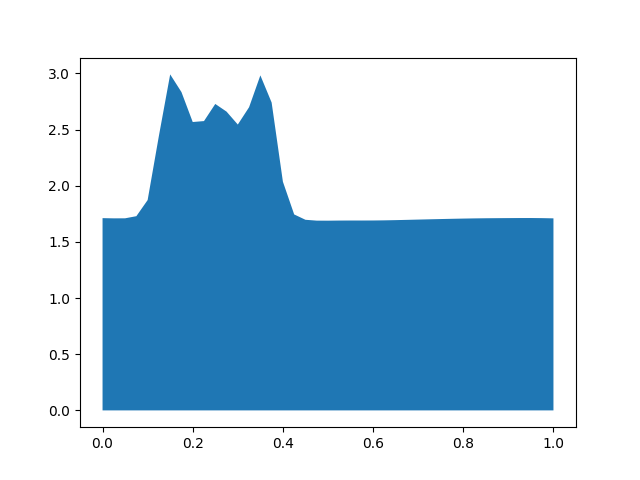

In [11]:
# Animate h

%matplotlib notebook

import matplotlib.pyplot as plt
import time as tim

fig1, ax1 = plt.subplots(1,1)

for i in range (0, number_of_timesteps + 1):

    _ = ax1.fill_between (grid, 0, h_array[:, i])
    fig1.canvas.draw()
    tim.sleep(0.02)
    
    if not i == number_of_timesteps:
        ax1.clear()